# Dipole antenna

This example shows how to use PyAEDT to create a dipole antenna in HFSS
and postprocess results.

Keywords: **HFSS**, **modal**, **antenna**, **3D components**, **far field**.

## Perform imports and define constants

Perform required imports.

In [1]:
import os
import tempfile
import time

In [2]:
import ansys.aedt.core

Define constants.

In [3]:
AEDT_VERSION = "2024.2"
NUM_CORES = 4
NG_MODE = False  # Open AEDT UI when it is launched.

## Create temporary directory

Create a temporary directory where downloaded data or
dumped data can be stored.
If you'd like to retrieve the project data for subsequent use,
the temporary folder name is given by ``temp_folder.name``.

In [4]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")

## Launch AEDT

In [5]:
d = ansys.aedt.core.launch_desktop(
    AEDT_VERSION, non_graphical=NG_MODE, new_desktop=True
)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_35b27942-f267-465a-99d7-62894c5cc4bd.log is enabled.


PyAEDT INFO: Log on AEDT is enabled.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Launching PyAEDT with gRPC plugin.


PyAEDT INFO: New AEDT session is starting on gRPC port 56045


PyAEDT INFO: AEDT installation Path C:\Program Files\AnsysEM\v242\Win64


PyAEDT INFO: Ansoft.ElectronicsDesktop.2024.2 version started with process ID 1944.


## Launch HFSS

Create an HFSS design.

In [6]:
project_name = os.path.join(temp_folder.name, "dipole.aedt")
hfss = ansys.aedt.core.Hfss(
    version=AEDT_VERSION, project=project_name, solution_type="Modal"
)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Returning found Desktop session with PID 1944!


PyAEDT INFO: Project dipole has been created.


PyAEDT INFO: No design is present. Inserting a new design.


PyAEDT INFO: Added design 'HFSS_Q9B' of type HFSS.


PyAEDT INFO: Aedt Objects correctly read


## Define variable

Define a variable for the dipole length.

In [7]:
hfss["l_dipole"] = "13.5cm"

## Get 3D component from system library

Get a 3D component from the ``syslib`` directory. For this example to run
correctly, you must get all geometry parameters of the 3D component or, in
case of an encrypted 3D component, create a dictionary of the parameters.

In [8]:
compfile = hfss.components3d["Dipole_Antenna_DM"]
geometryparams = hfss.get_components3d_vars("Dipole_Antenna_DM")
geometryparams["dipole_length"] = "l_dipole"
hfss.modeler.insert_3d_component(compfile, geometryparams)

PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 1sec


PyAEDT INFO: Parsing C:/Users/ansys/AppData/Local/Temp/tmpggme2uec.ansys/dipole.aedt.


PyAEDT INFO: File C:/Users/ansys/AppData/Local/Temp/tmpggme2uec.ansys/dipole.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.0010402202606201172


## Create boundaries

Create an open region.

In [9]:
hfss.create_open_region(frequency="1GHz")

PyAEDT INFO: Open Region correctly created.


PyAEDT INFO: Project dipole Saved correctly


True

## Create setup

Create a setup with a sweep to run the simulation.

In [10]:
setup = hfss.create_setup("MySetup")
setup.props["Frequency"] = "1GHz"
setup.props["MaximumPasses"] = 1
hfss.create_linear_count_sweep(
    setup=setup.name,
    units="GHz",
    start_frequency=0.5,
    stop_frequency=1.5,
    num_of_freq_points=101,
    name="sweep1",
    sweep_type="Interpolating",
    interpolation_tol=3,
    interpolation_max_solutions=255,
    save_fields=False,
)

PyAEDT INFO: Linear count sweep sweep1 has been correctly created.


## Run simulation

In [11]:
hfss.analyze_setup(name="MySetup", cores=NUM_CORES)

PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS correctly changed.


PyAEDT INFO: Solving design setup MySetup


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS correctly changed.


PyAEDT INFO: Design setup MySetup solved correctly in 0.0h 0.0m 25.0s


True

### Postprocess

Plot s-parameters and far field.

In [12]:
hfss.create_scattering("MyScattering")
variations = hfss.available_variations.nominal_w_values_dict
variations["Freq"] = ["1GHz"]
variations["Theta"] = ["All"]
variations["Phi"] = ["All"]
hfss.post.create_report(
    "db(GainTotal)",
    hfss.nominal_adaptive,
    variations,
    primary_sweep_variable="Theta",
    context="3D",
    report_category="Far Fields",
)

PyAEDT INFO: Parsing C:/Users/ansys/AppData/Local/Temp/tmpggme2uec.ansys/dipole.aedt.


PyAEDT INFO: File C:/Users/ansys/AppData/Local/Temp/tmpggme2uec.ansys/dipole.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.015634775161743164


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


Create a far fields report using the ``report_by_category.far field()`` method.

In [13]:
new_report = hfss.post.reports_by_category.far_field(
    "db(RealizedGainTotal)", hfss.nominal_adaptive, "3D"
)
new_report.variations = variations
new_report.primary_sweep = "Theta"
new_report.create("Realized2D")

True

Generate multiple plots using the ``new_report`` object. This code generates
2D and 3D polar plots.

In [14]:
new_report.report_type = "3D Polar Plot"
new_report.secondary_sweep = "Phi"
new_report.create("Realized3D")

True

Get solution data using the ``new_report`` object and postprocess or plot the
data outside AEDT.

PyAEDT INFO: Solution Data Correctly Loaded.


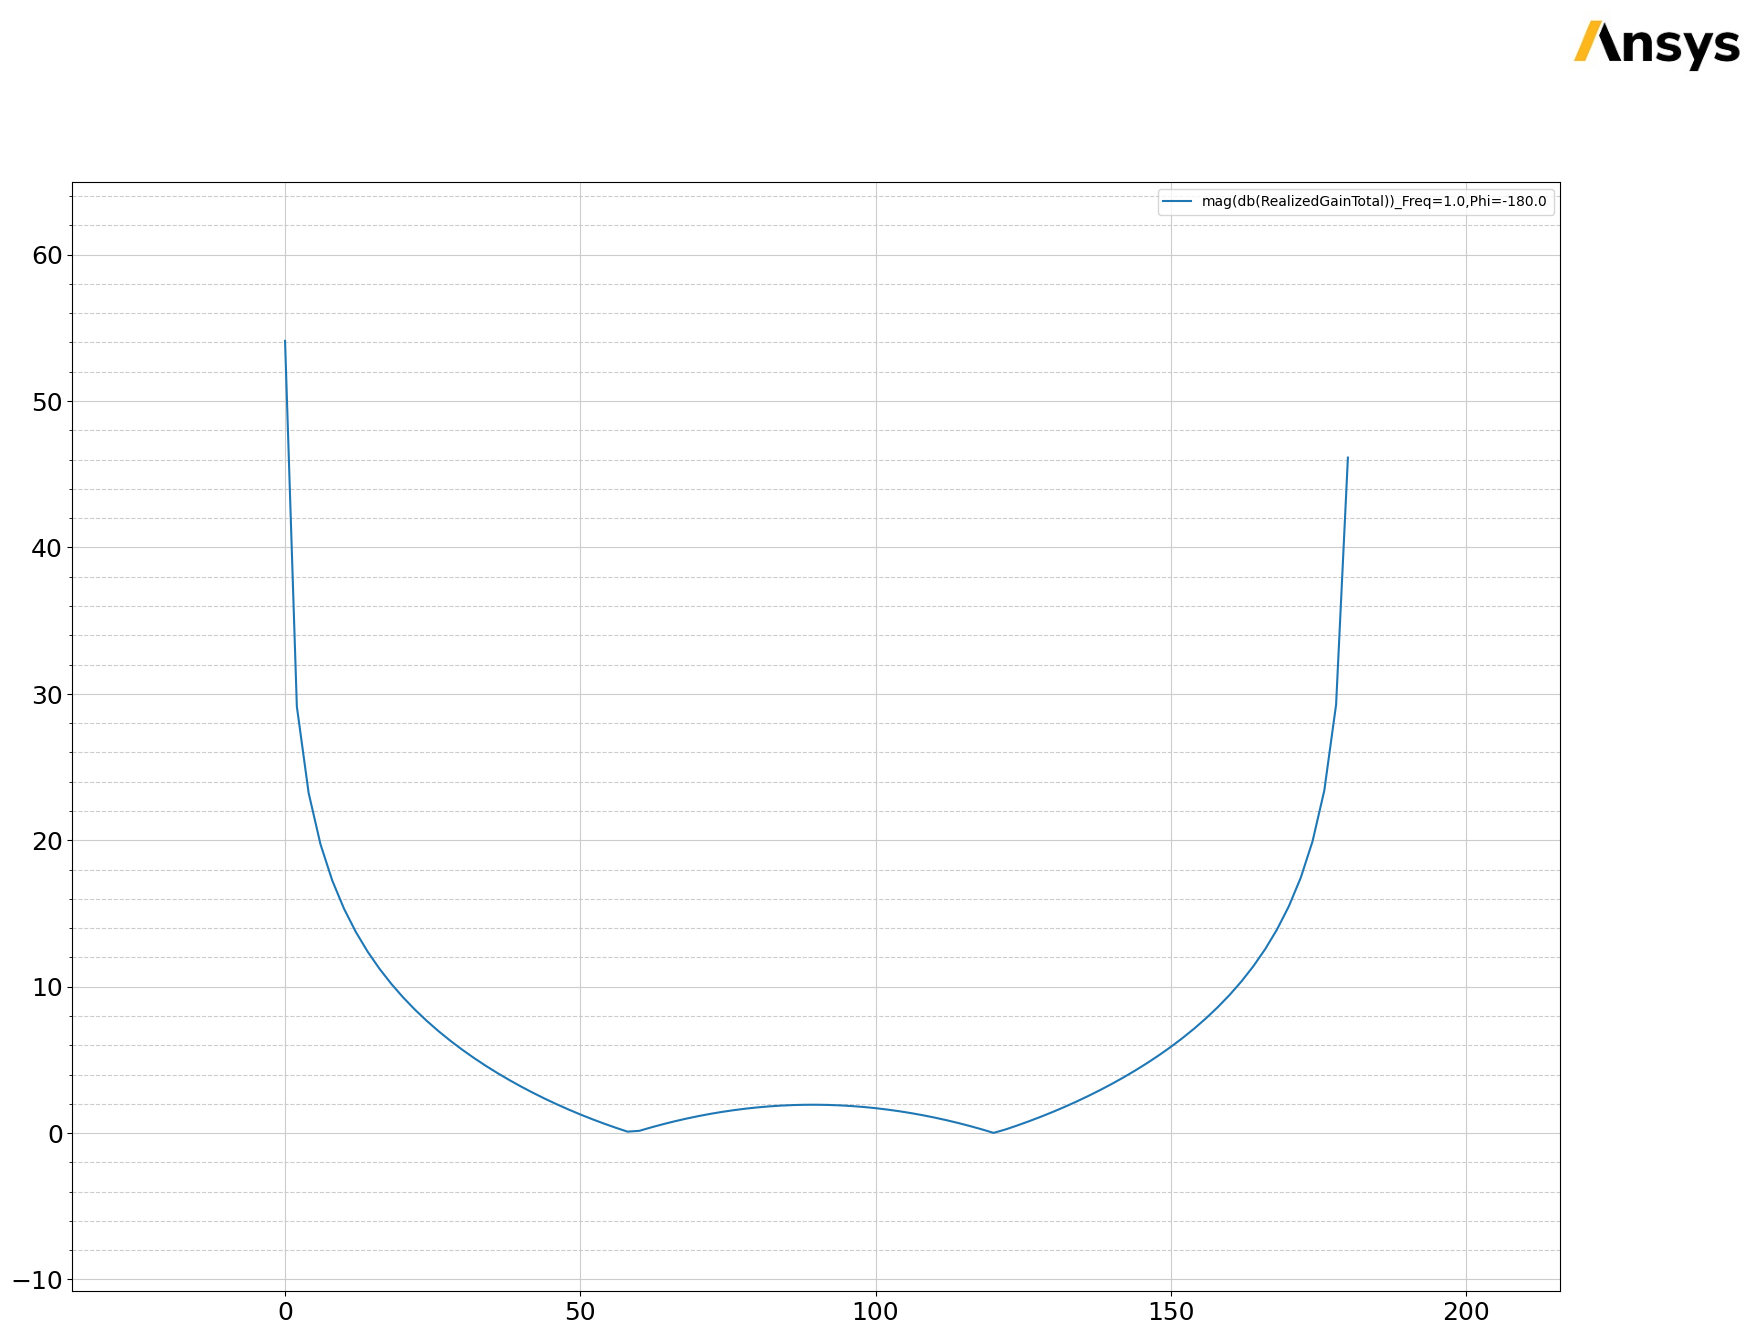

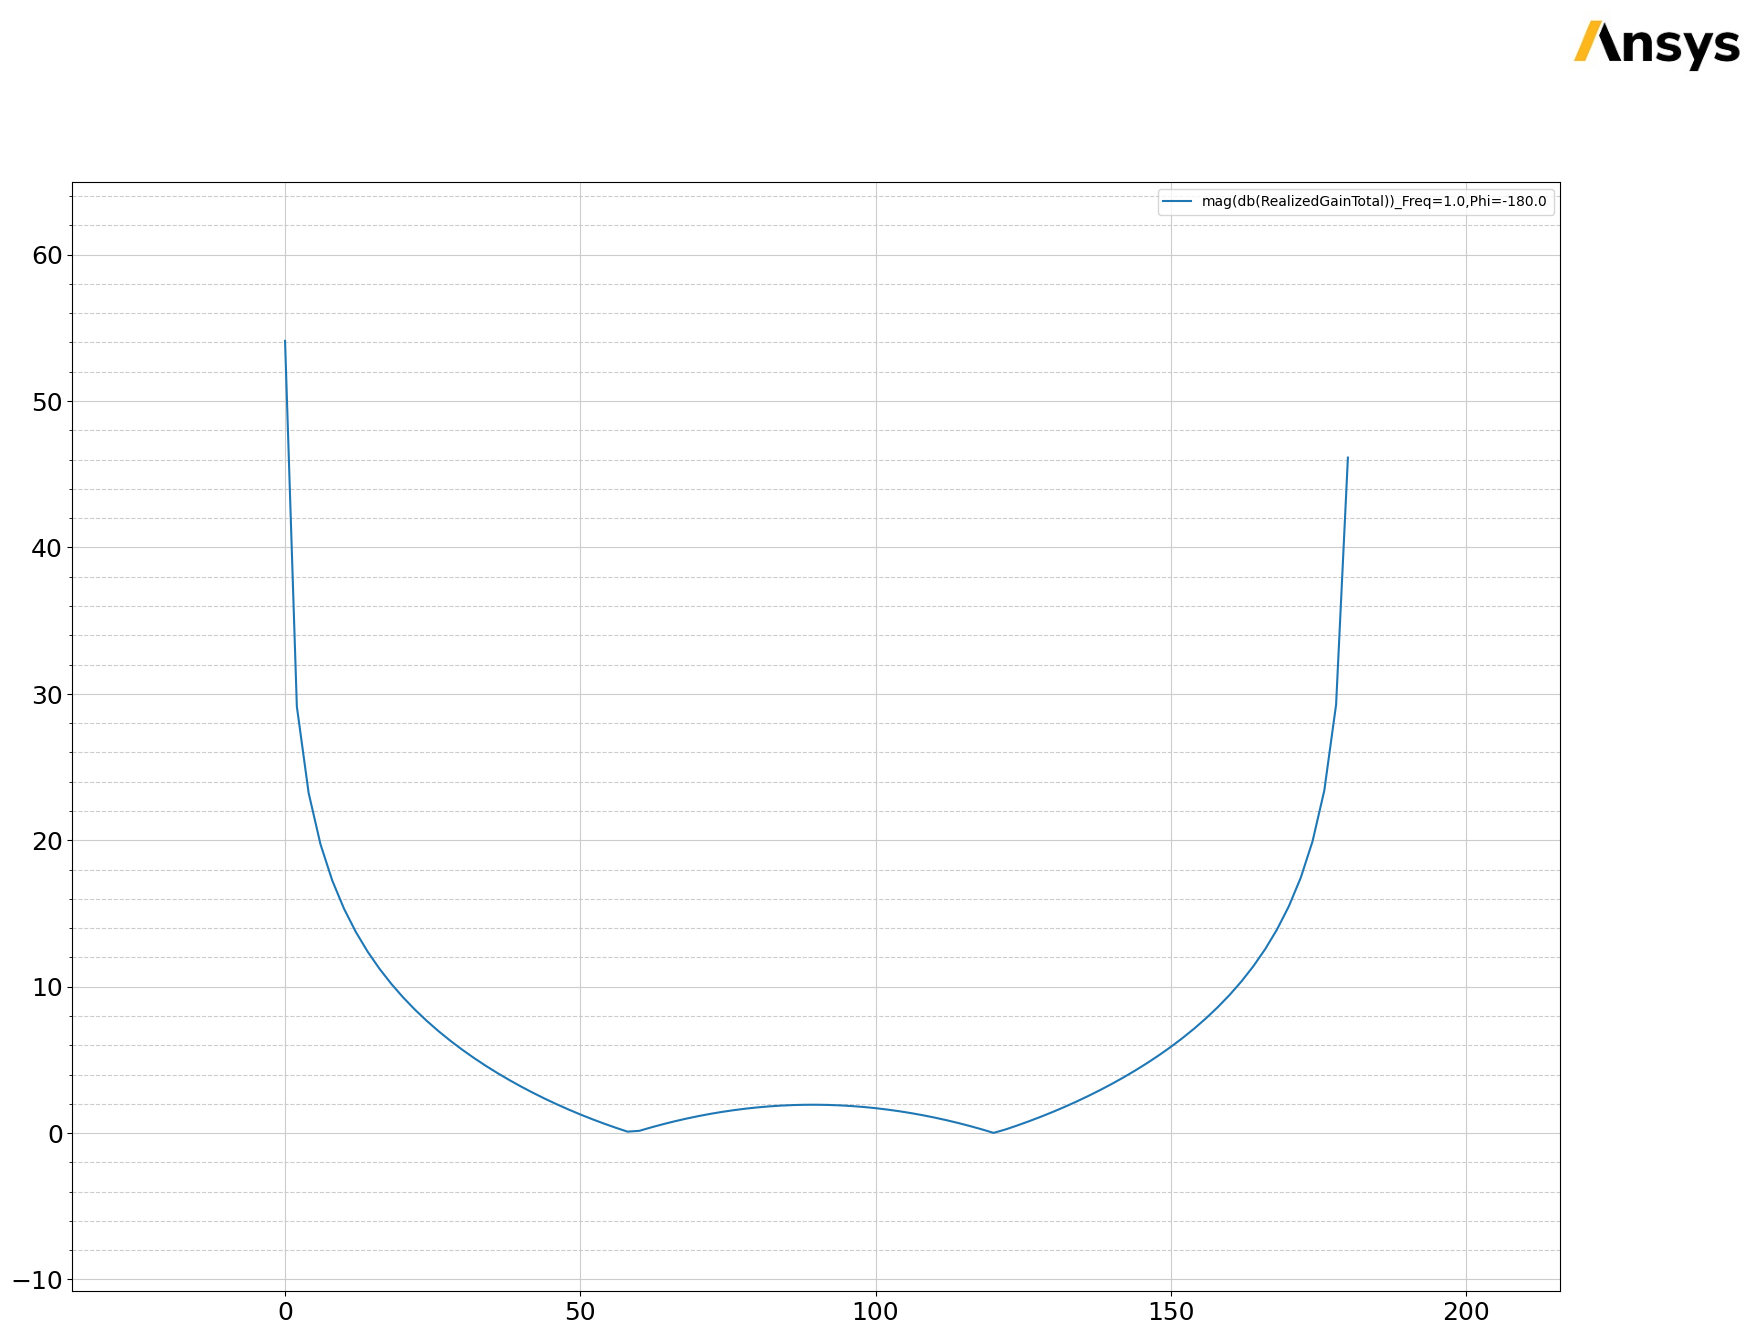

In [15]:
solution_data = new_report.get_solution_data()
solution_data.plot()

Generate a far field plot by creating a postprocessing variable and assigning
it to a new coordinate system. You can use the ``post`` prefix to create a
postprocessing variable directly from a setter, or you can use the ``set_variable()``
method with an arbitrary name.

In [16]:
hfss["post_x"] = 2
hfss.variable_manager.set_variable(name="y_post", expression=1, is_post_processing=True)
hfss.modeler.create_coordinate_system(origin=["post_x", "y_post", 0], name="CS_Post")
hfss.insert_infinite_sphere(custom_coordinate_system="CS_Post", name="Sphere_Custom")

## Retrieve solution data

You can also process solution data using Python libraries like Matplotlib.

In [17]:
new_report = hfss.post.reports_by_category.far_field(
    "GainTotal", hfss.nominal_adaptive, "3D"
)
new_report.primary_sweep = "Theta"
new_report.far_field_sphere = "3D"
solutions = new_report.get_solution_data()

PyAEDT INFO: Solution Data Correctly Loaded.


Generate a 3D plot using Matplotlib.

In [18]:
solutions.plot_3d()

PyAEDT ERROR: **************************************************************


PyAEDT ERROR:   File "C:\Users\ansys\AppData\Local\Programs\Python\Python310\Lib\runpy.py", line 196, in _run_module_as_main


PyAEDT ERROR:     return _run_code(code, main_globals, None,


PyAEDT ERROR:   File "C:\Users\ansys\AppData\Local\Programs\Python\Python310\Lib\runpy.py", line 86, in _run_code


PyAEDT ERROR:     exec(code, run_globals)


PyAEDT ERROR:   File "C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\ipykernel_launcher.py", line 18, in <module>


PyAEDT ERROR:     app.launch_new_instance()


PyAEDT ERROR:   File "C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance


PyAEDT ERROR:     app.start()


PyAEDT ERROR:   File "C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\ipykernel\kernelapp.py", line 739, in start


PyAEDT ERROR:     self.io_loop.start()


PyAEDT ERROR:   File "C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\tornado\platform\asyncio.py", line 205, in start


PyAEDT ERROR:     self.asyncio_loop.run_forever()


PyAEDT ERROR:   File "C:\Users\ansys\AppData\Local\Programs\Python\Python310\Lib\asyncio\base_events.py", line 603, in run_forever


PyAEDT ERROR:     self._run_once()


PyAEDT ERROR:   File "C:\Users\ansys\AppData\Local\Programs\Python\Python310\Lib\asyncio\base_events.py", line 1909, in _run_once


PyAEDT ERROR:     handle._run()


PyAEDT ERROR:   File "C:\Users\ansys\AppData\Local\Programs\Python\Python310\Lib\asyncio\events.py", line 80, in _run


PyAEDT ERROR:     self._context.run(self._callback, *self._args)


PyAEDT ERROR:   File "C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue


PyAEDT ERROR:     await self.process_one()


PyAEDT ERROR:   File "C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one


PyAEDT ERROR:     await dispatch(*args)


PyAEDT ERROR:   File "C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell


PyAEDT ERROR:     await result


PyAEDT ERROR:   File "C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request


PyAEDT ERROR:     await super().execute_request(stream, ident, parent)


PyAEDT ERROR:   File "C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request


PyAEDT ERROR:     reply_content = await reply_content


PyAEDT ERROR:   File "C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute


PyAEDT ERROR:     res = shell.run_cell(


PyAEDT ERROR:   File "C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell


PyAEDT ERROR:     return super().run_cell(*args, **kwargs)


PyAEDT ERROR:   File "C:\Users\ansys\AppData\Local\Temp\ipykernel_2292\3582042235.py", line 1, in <module>


PyAEDT ERROR:     solutions.plot_3d()


PyAEDT ERROR:   File "C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\ansys\aedt\core\visualization\post\solution_data.py", line 966, in plot_3d


PyAEDT ERROR:     min_r = min(min_r, el.values.min())


PyAEDT ERROR: 'list' object has no attribute 'values' on plot_3d


PyAEDT ERROR: **************************************************************


False

Generate a far fields plot using Matplotlib.

In [19]:
new_report.far_field_sphere = "Sphere_Custom"
solutions_custom = new_report.get_solution_data()
solutions_custom.plot_3d()

PyAEDT INFO: Solution Data Correctly Loaded.


PyAEDT ERROR: **************************************************************


PyAEDT ERROR:   File "C:\Users\ansys\AppData\Local\Programs\Python\Python310\Lib\runpy.py", line 196, in _run_module_as_main


PyAEDT ERROR:     return _run_code(code, main_globals, None,


PyAEDT ERROR:   File "C:\Users\ansys\AppData\Local\Programs\Python\Python310\Lib\runpy.py", line 86, in _run_code


PyAEDT ERROR:     exec(code, run_globals)


PyAEDT ERROR:   File "C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\ipykernel_launcher.py", line 18, in <module>


PyAEDT ERROR:     app.launch_new_instance()


PyAEDT ERROR:   File "C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance


PyAEDT ERROR:     app.start()


PyAEDT ERROR:   File "C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\ipykernel\kernelapp.py", line 739, in start


PyAEDT ERROR:     self.io_loop.start()


PyAEDT ERROR:   File "C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\tornado\platform\asyncio.py", line 205, in start


PyAEDT ERROR:     self.asyncio_loop.run_forever()


PyAEDT ERROR:   File "C:\Users\ansys\AppData\Local\Programs\Python\Python310\Lib\asyncio\base_events.py", line 603, in run_forever


PyAEDT ERROR:     self._run_once()


PyAEDT ERROR:   File "C:\Users\ansys\AppData\Local\Programs\Python\Python310\Lib\asyncio\base_events.py", line 1909, in _run_once


PyAEDT ERROR:     handle._run()


PyAEDT ERROR:   File "C:\Users\ansys\AppData\Local\Programs\Python\Python310\Lib\asyncio\events.py", line 80, in _run


PyAEDT ERROR:     self._context.run(self._callback, *self._args)


PyAEDT ERROR:   File "C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue


PyAEDT ERROR:     await self.process_one()


PyAEDT ERROR:   File "C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one


PyAEDT ERROR:     await dispatch(*args)


PyAEDT ERROR:   File "C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell


PyAEDT ERROR:     await result


PyAEDT ERROR:   File "C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request


PyAEDT ERROR:     await super().execute_request(stream, ident, parent)


PyAEDT ERROR:   File "C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request


PyAEDT ERROR:     reply_content = await reply_content


PyAEDT ERROR:   File "C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute


PyAEDT ERROR:     res = shell.run_cell(


PyAEDT ERROR:   File "C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell


PyAEDT ERROR:     return super().run_cell(*args, **kwargs)


PyAEDT ERROR:   File "C:\Users\ansys\AppData\Local\Temp\ipykernel_2292\883247503.py", line 3, in <module>


PyAEDT ERROR:     solutions_custom.plot_3d()


PyAEDT ERROR:   File "C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\ansys\aedt\core\visualization\post\solution_data.py", line 966, in plot_3d


PyAEDT ERROR:     min_r = min(min_r, el.values.min())


PyAEDT ERROR: 'list' object has no attribute 'values' on plot_3d


PyAEDT ERROR: **************************************************************


False

Generate a 2D plot using Matplotlib where you specify whether it is a polar
plot or a rectangular plot.

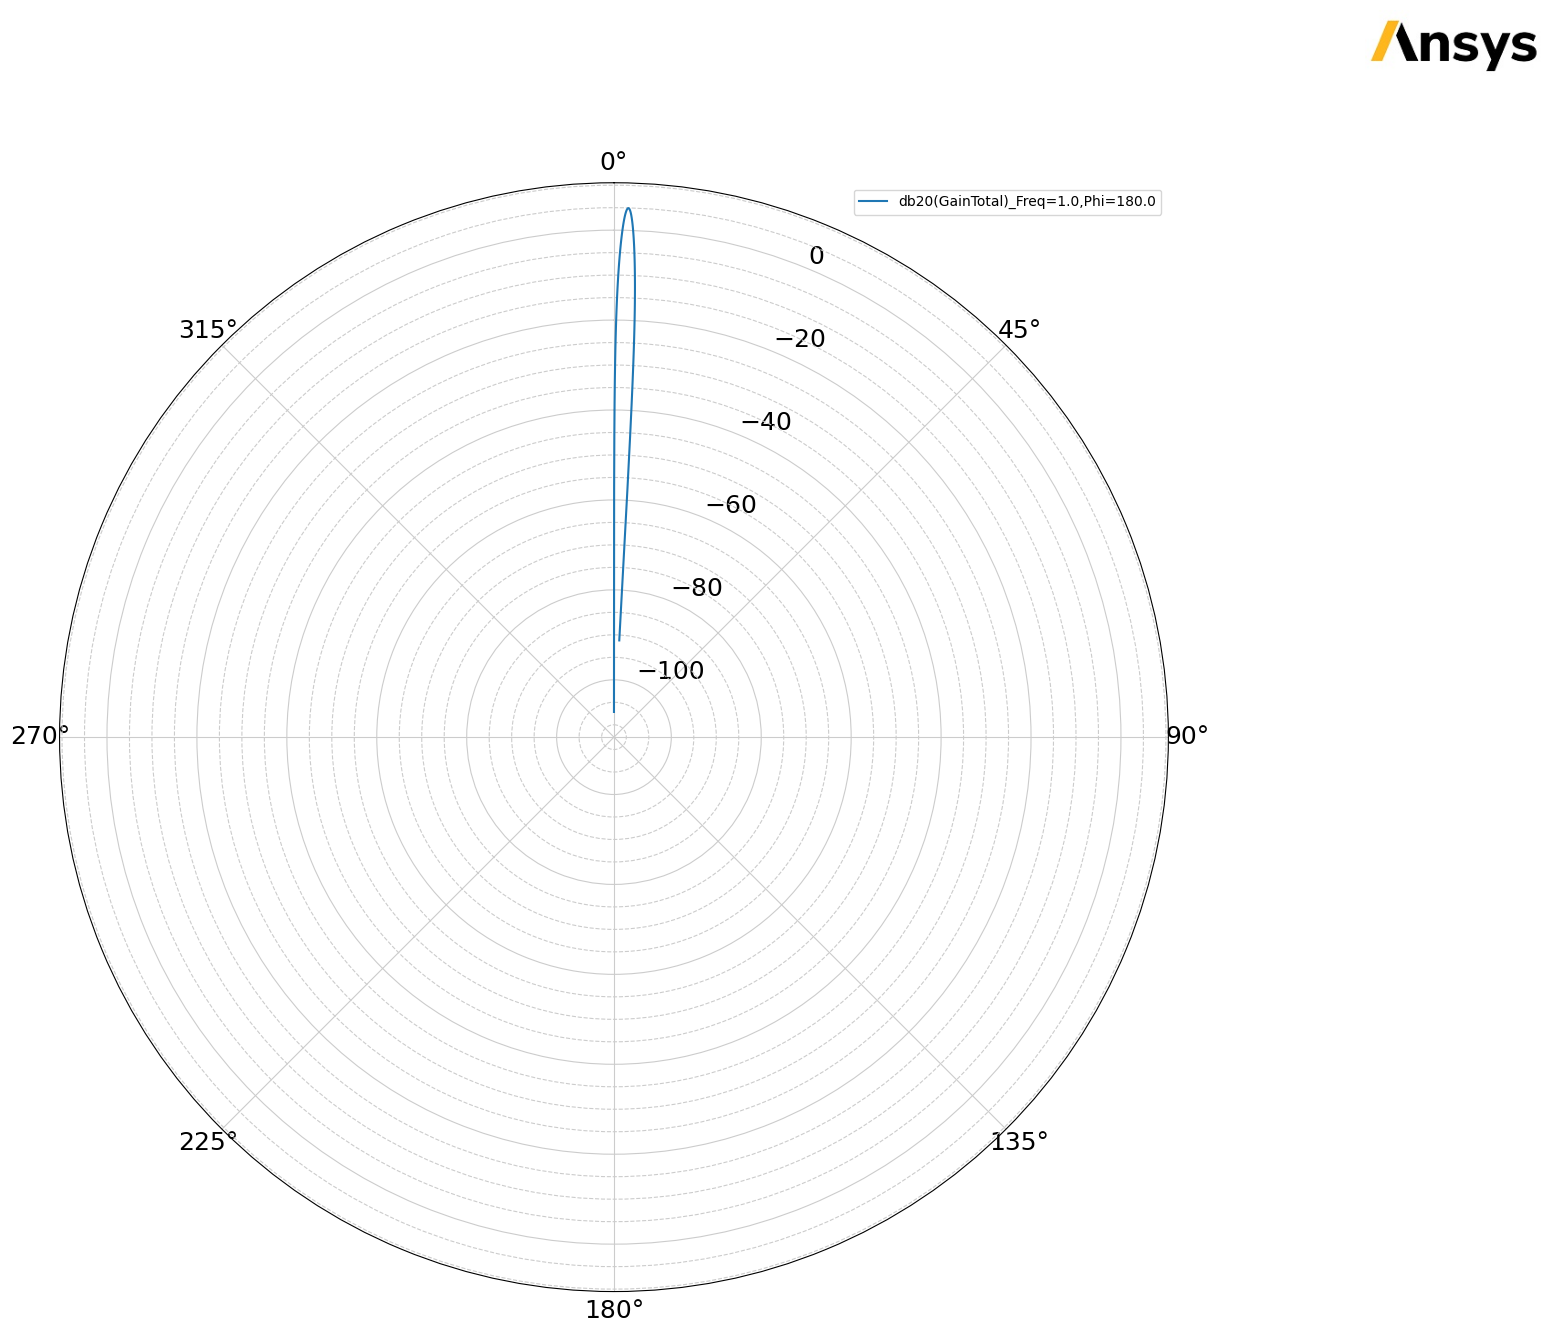

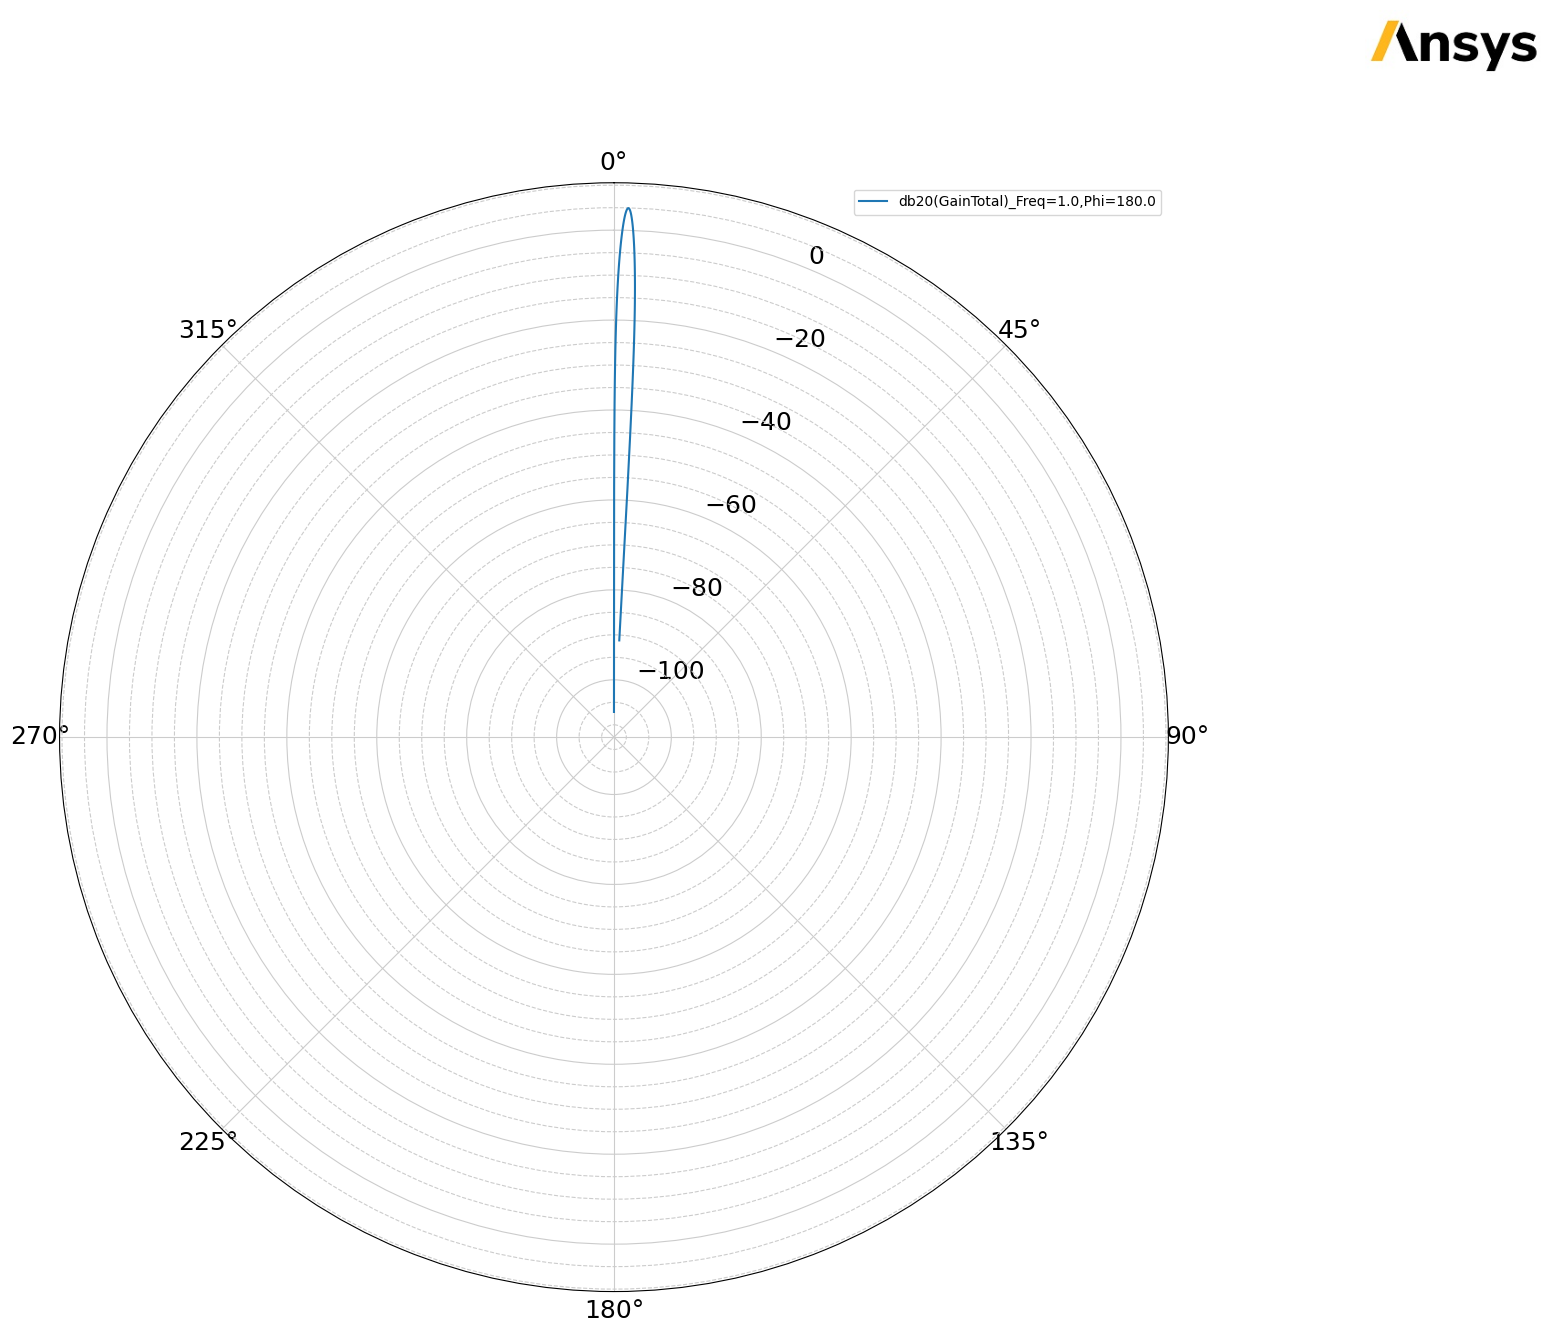

In [20]:
solutions.plot(formula="db20", is_polar=True)

## Retrieve far-field data

After the simulation completes, the far
field data is generated port by port and stored in a data class. You can use this data
once AEDT is released.

In [21]:
ffdata = hfss.get_antenna_data(
    sphere="Sphere_Custom",
    setup=hfss.nominal_adaptive,
    frequencies=["1000MHz"],
)

PyAEDT INFO: Far field sphere Sphere_Custom is assigned


PyAEDT INFO: Exporting antenna metadata...


PyAEDT INFO: Antenna metadata exported.


PyAEDT INFO: Exporting geometry...


PyAEDT INFO: Exporting embedded element patterns.... Done: 0.42682671546936035 seconds


## Generate 2D cutout plot

Generate a 2D cutout plot. You can define the Theta scan
and Phi scan.

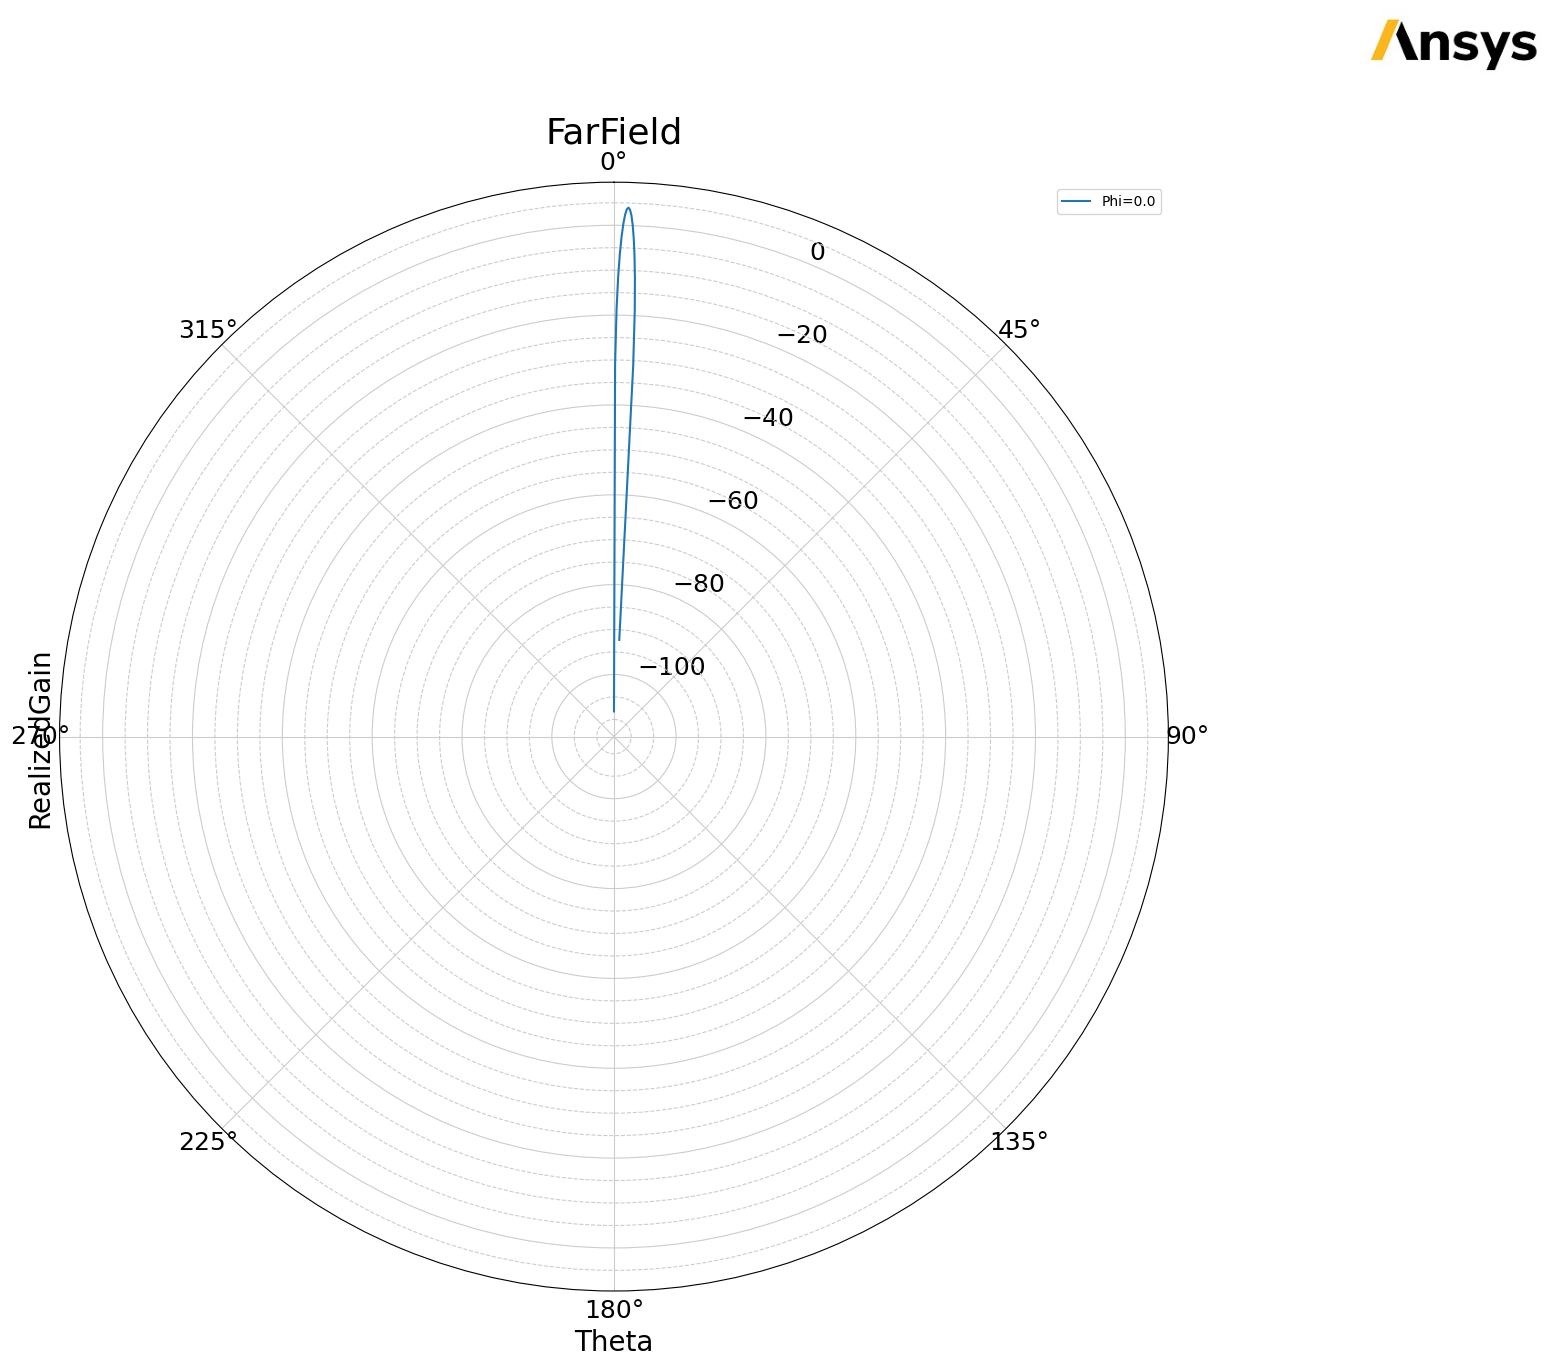

In [22]:
ffdata.farfield_data.plot_cut(
    primary_sweep="theta",
    secondary_sweep_value=0,
    quantity="RealizedGain",
    title="FarField",
    quantity_format="dB20",
    is_polar=True,
)

## Release AEDT

In [23]:
hfss.save_project()
d.release_desktop()
# Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(3)

PyAEDT INFO: Project dipole Saved correctly


PyAEDT INFO: Desktop has been released and closed.


## Clean up

All project files are saved in the folder ``temp_folder.name``.
If you've run this example as a Jupyter notebook, you
can retrieve those project files.
The following cell removes all temporary files, including the project folder.

In [24]:
temp_folder.cleanup()